# Self-organizing maps

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle
import pandas as pd
import geopandas as gpd

#set random seed for reproducability
s = 0
seed = np.random.seed(s)

In [108]:
class SOM:
    
    "This is the self-organizing map class."
    
    def __init__(self, Nx, Ny, obs, N_epochs):
        
        """
        Initialize attributes
        
        obs: array of all obserations; rows = observations, columns = dimensions
        Nx: number of map nodes in x-direction (number of columns)
        Ny: number of map nodes in y-direction (number of rows)
        sigma_max: maximum standard deviation for gaussian neighbourhood
        sigma_min: minimum standard deviation for gaussian neighbourhood
        N_epochs: the number of epochs to train the map for
        
        """
        
        self.Nx = Nx
        self.Ny = Ny
        self.obs = obs
        self.sigma_max = 1.0
        self.sigma_min = 0.1
        self.N_epochs = N_epochs
        self.sigmas = np.zeros(self.N_epochs)
        
    def initialize_map(self, node_shape = 'hex'):

        """
        Use principal component analysis to initialize the SOM as a grid in the space of PC1 and PC2
        
        node_shape: 'hex' or 'rect'
        """

        #PCA initialize
        pca = PCA(n_components = 2)
        PCs = pca.fit_transform(self.obs)
        frac_var = pca.explained_variance_ratio_
        var = pca.explained_variance_
        std = var**0.5
        eigvecs = pca.components_

        #evenly space out Nx points along first eigenvector, Ny points along second eigenvector
        mid = np.mean(self.obs, axis = 0)
        x_PC_space = np.linspace(-std[0], std[0], self.Nx)
        y_PC_space = np.linspace(-std[1], std[1], self.Ny)

        node = 0
        z_init = np.zeros((self.Nx*self.Ny, len(self.obs[0,:]))) #numer of dimensions of z is the same as the number of dimensions in the observations
        i_init = np.zeros((self.Nx*self.Ny, 2)) #i is 2-dimensional (since map-space is 2D)
        for kk in range(self.Nx):
            for jj in range(self.Ny):

                z_init[node,:] = mid + x_PC_space[kk]*eigvecs[0,:] + y_PC_space[jj]*eigvecs[1,:] #row, column == x, y position in data-space

                if node_shape == 'rect':
                    i_init[node,:] = np.array([kk,jj]) #row, column == x, y position in map-space
                elif node_shape == 'hex':
                    ix = np.mod(jj,2) * 0.5 + kk #odd rows (jj-->Ny-->rows) have shift from stacking
                    iy = np.sqrt(3)/2 * jj
                    i_init[node,:] = np.array([ix,iy])

                node+=1
                
        self.z_init = z_init
        self.i_init = i_init
        
        self.z = z_init
        self.i = i_init

    def neighbourhood(self, x, sigma = 1):
        
        """
        Calculates the gaussian neighbourhood distance.
        x: distance from gaussian mean
        sigma: standard deviation of gaussian
        
        """
        
        #gaussian
        d = np.exp(-0.5*(x/sigma)**2)
        return d
    
    def sigma_linear(self, epoch):
        
        """
        This function returns sigma (standard deviation of neighbourhood function), which undergoes a linear decrease over 
        all epochs, starting at sigma_max and ending at sigma_min
        
        sigma_max: initial sigma at epoch 
        sigma_min: final minimum sigma at last epoch
        epoch: current training epoch (int)
        
        """
        
        sigmas = np.linspace(self.sigma_max, self.sigma_min, self.N_epochs)
        sigma = sigmas[epoch]
        
        return sigma
    
    def train_step(self, obs, sigma):
        
        """
        This function performs one training step (epoch).  Each observation is passed through the map and the map nodes are updated.
        
        obs: array of all obserations; rows = observations, columns = dimensions
        sigma: the standard deviation of gaussian neighbourhood function
        
        """
        
        for kk, ob in enumerate(obs):

            BMU = np.argmin(np.linalg.norm(ob-self.z, axis = 1)) #current BMU
            zk = self.z[BMU,:] #current node (in data space) of the BMU node
            ik = self.i[BMU,:] #current node (in map space) of the BMU node
            i2 = np.linalg.norm(self.i - ik, axis = -1)**2 #(i_j - i_k)^2, for all j
            
            self.z = self.z + learning_rate * self.neighbourhood(i2, sigma)[:,None] * (ob - self.z) #update nodes in data space

    def train_map(self, learning_rate):
        
        """
        This function iteratively trains the map.
        
        N_epochs: integer, the number of epochs to train the map
        learning_rate: float, the learning rate to use in the map update calculation
        
        """

        sigma_max = self.sigma_max
        sigma_min = self.sigma_min

        N_nodes = self.Nx * self.Ny
        N_dims = np.shape(self.obs)[-1]
        z_epochs = np.zeros((N_nodes, N_dims, self.N_epochs+1)) #nodes in data-space at end of each epoch
        z_epochs[:,:,0] = self.z_init

        for epoch in range(N_epochs): #for each epoch

            #shuffle data -- present data to map in a different order 
            obs_shuffle = np.copy(self.obs)
            np.random.shuffle(obs_shuffle)

            #calculate neighbourhood radius 
            sigma = self.sigma_linear(epoch)
            self.sigmas[epoch] = sigma

            #do one training step
            self.train_step(obs = obs_shuffle, sigma = sigma)
            z_epochs[:,:,epoch+1] = self.z

        self.z_epochs = z_epochs
        
    def plot(self):
        
        """
        This function plots the nodes of the map in subplots.
        
        """
        
        border = 0.1*(np.max(self.z) - np.min(self.z))
        indices = np.arange(N_nodes).reshape(Nx,Ny).T.flatten()
        
        fig, axes = plt.subplots(nrows = self.Ny, ncols = self.Nx, figsize = (3*self.Nx, 3*self.Ny))
        
        for kk, ax in enumerate(axes.flatten()): #for each axis (subplot)
            var = self.z[indices[kk],:]
            ax.plot(var)
            ax.set_ylim(bottom = np.min(self.z)-border, top = np.max(self.z)+border)
            ax.set_title('Node ' + str(indices[kk]))
            
        plt.tight_layout()
        
        return fig, axes
        
def BMUs(SOM):

    """
    Calculates the best matching unit (BMU) for each observation.

    """    

    BMUs = np.zeros(len(SOM.obs))

    for kk, ob in enumerate(SOM.obs):

        BMU = np.argmin(np.linalg.norm(ob-SOM.z, axis = 1))
        BMUs[kk] = BMU

    return BMUs

def BMU_frequency(SOM):

    bmus = BMUs(SOM)
    frequency = np.zeros(SOM.Nx * SOM.Ny)
    for node in range(SOM.Nx * SOM.Ny):
        n_node = len(np.argwhere(bmus == node))
        frequency[node] = n_node / len(SOM.obs)

    return frequency

# Example: Random clusters of 2D data

In [125]:
def generate_blobs(N_blobs, N_points, s):
    
    np.random.seed(s)
    
    x = np.zeros(N_points)
    y = np.zeros(N_points)
    
    start = 0
    for blob in range(N_blobs):
        N_points_this_blob = int(np.floor(N_points/N_blobs))
        if blob == N_blobs-1:
            N_points_this_blob += np.mod(N_points, N_blobs)
            
        fin = start + N_points_this_blob
        x[start:fin] = np.random.random(1)*2
        y[start:fin] = np.random.random(1)*2
        start = fin
        
    scale = 0.05*N_blobs / (N_blobs - 1)
        
    noise_x = np.random.normal(size = N_points, scale = scale)
    noise_y = np.random.normal(size = N_points, scale = scale)
    
    x += noise_x
    y += noise_y
    
    x = (x - np.mean(x)) / np.std(x)
    y = (y - np.mean(y)) / np.std(y)
    
    return x,y

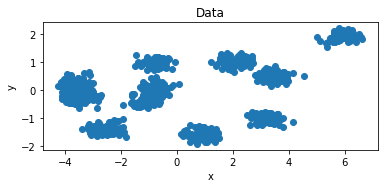

In [137]:
#generate and visualize data

x,y = generate_blobs(12,1000,s=3)
x *= 3 #scale in x-direction
obs = np.vstack([x,y]).T #all observations: row = observation, column = dimension

fig, ax = plt.subplots()
ax.scatter(x,y)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Data')
ax.set_aspect('equal')

In [138]:
#make and train the self-organizing map

#define constants
Nx = 4
Ny = 3
N_nodes = Nx*Ny
N_obs = np.shape(obs)[0] #number of observations 
N_dims = np.shape(obs)[1] #number of dimensions per observation
learning_rate = 1e-2
N_epochs = 500

#initialize
som = SOM(Nx, Ny, obs, N_epochs)
som.initialize_map(node_shape = 'hex')

#train
som.train_map(learning_rate)
z = som.z_epochs
bmus = BMUs(som)
freq = BMU_frequency(som)

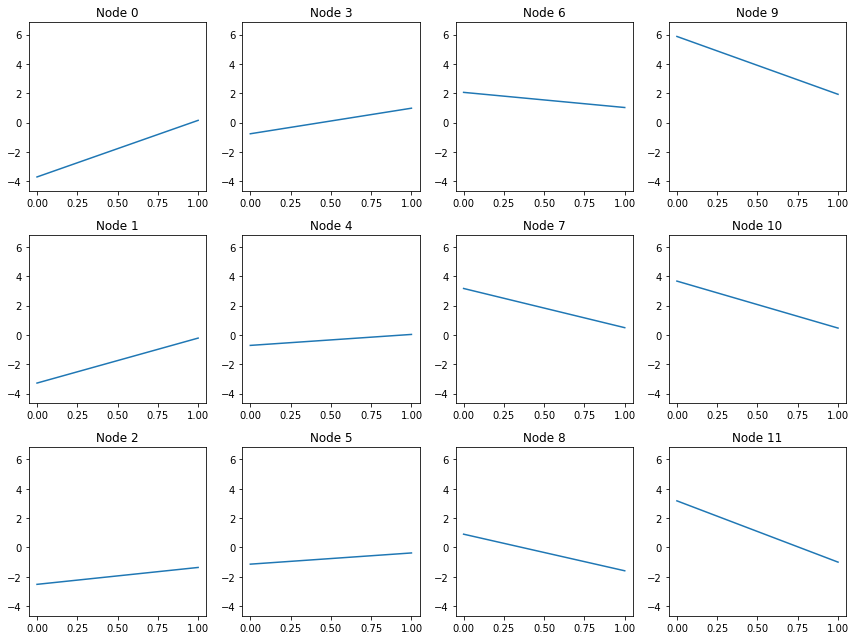

In [139]:
#visualize the SOM in map-space
fig, axes = som.plot()

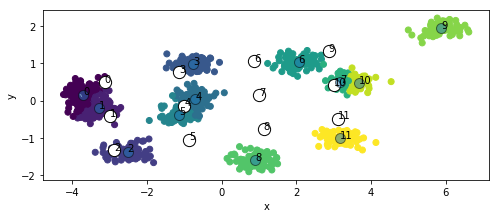

In [141]:
#visualize data, clusters, and map nodes in data-space

fig, ax = plt.subplots(figsize = (8,6))

ax.scatter(obs[:,0],obs[:,1], c = bmus) #observations, coloured by BMU
ax.scatter(z[:,0,0],z[:,1,0], s = 150, edgecolor = 'k', facecolor = 'w') #intial SOM nodes
ax.scatter(z[:,0,-1],z[:,1,-1], edgecolor = 'k', s = 100, alpha = 0.5) #final SOM nodes
ax.set_aspect('equal') #set distance in x- and y- directions to be the same visually
ax.set_xlabel('x') 
ax.set_ylabel('y')


#below: label node numbers to see which nodes are which

x = z[:,0,0]
y = z[:,1,0]
s = np.array([str(kk) for kk in range(N_nodes)])
for kk in range(N_nodes):
    ax.text(x = x[kk], y = y[kk], s = s[kk])
    
x = z[:,0,-1]
y = z[:,1,-1]
s = np.array([str(kk) for kk in range(N_nodes)])
for kk in range(N_nodes):
    ax.text(x = x[kk], y = y[kk], s = s[kk])

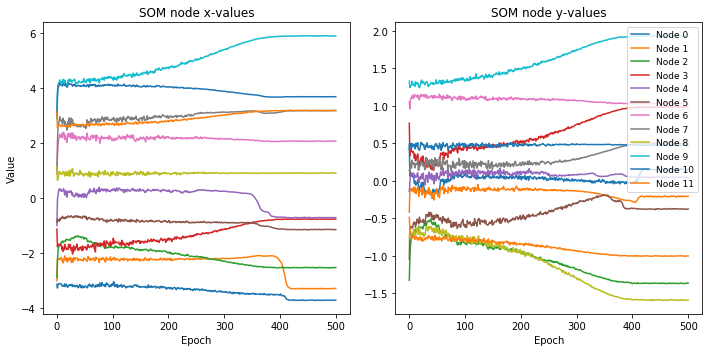

In [144]:
#visualize how som nodes in data-space change through training -- when these stabalize, it is a sign that the map has converged

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

for node in range(N_nodes):
    ax[0].plot(som.z_epochs[node,0,:].T)
    ax[1].plot(som.z_epochs[node,1,:].T, label = 'Node ' + str(node))

ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Value')
ax[0].set_title('SOM node x-values')
ax[1].set_title('SOM node y-values')
ax[1].legend(fontsize = 9)

plt.tight_layout()
plt.show()

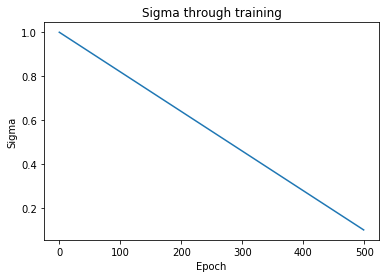

In [147]:
#visualize how sigma varies through time

fig, ax = plt.subplots()

ax.plot(som.sigmas)
ax.set_xlabel('Epoch')
ax.set_ylabel('Sigma')
ax.set_title('Sigma through training')

plt.show()

# Example: Seasonal streamflow in south-western Canada

In [199]:
#define a function to plot provincial borders

def plot_prov_ax(prov, ax):

  """
  plot borders of a province on a given axis

  prov: list of strings of provincial abbreviations; ['AB'], ['BC'], ['AB','BC'], etc; prov = 'all' will plot all provincial/territorial borders
  ax: axis on which to plot the provincial borders

  Examples:

  fig, ax = plt.subplots()
  plot_prov_ax(prov = ['BC', 'AB', 'SK'], ax = ax) #plots British Colubmia, Alberta, and Saskatchewan

  fig, ax = plt.subplots()
  plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
  """

  #load shapefile of provincial boundaries
  provshapes_filename = './Data/PROVINCE.SHP'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial abbreviations
  prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_abbreviations

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if len(np.shape(prov_poly)) == 0: #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      ax.plot(lonBorder,latBorder,'k')

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly)): 
        lonBorder_segment,latBorder_segment = prov_poly[ind].exterior.coords.xy 
        ax.plot(lonBorder_segment,latBorder_segment,'k')

In [200]:
#load data
dir_data = './Data/' #folder where data is saved

#load seasonal flow
pickle_in = open(dir_data + 'flowseason_norm.pickle','rb')
flowseason_norm = pickle.load(pickle_in).T

#load station_data
df = pd.read_csv(dir_data + 'station_info.csv')
stationLon = df['Longitude'].values
stationLat = df['Latitude'].values
Nstations = len(stationLat)

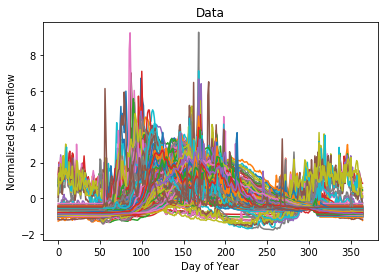

In [183]:
#visualize seasonal streamflow data in time

obs = flowseason_norm

fig, ax = plt.subplots()
for ob in obs:
    ax.plot(ob)
ax.set_xlabel('Day of Year')
ax.set_ylabel('Normalized Streamflow')
ax.set_title('Data')

plt.show()

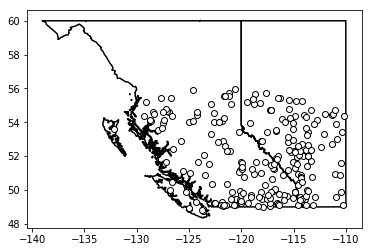

In [201]:
#visualize station locations

fig, ax = plt.subplots()
plot_prov_ax(['BC','AB'], ax)
ax.scatter(stationLon,stationLat, zorder = 5, facecolor = 'w', edgecolor = 'k')

In [202]:
#make and train the self-organizing map

#define constants
Nx = 3
Ny = 2
N_nodes = Nx*Ny
N_obs = np.shape(obs)[0] #number of observations 
N_dims = np.shape(obs)[1] #number of dimensions per observation
learning_rate = 1e-2
N_epochs = 100

#initialize
som = SOM(Nx, Ny, obs, N_epochs)
som.initialize_map(node_shape = 'hex')

#train
som.train_map(learning_rate)
z = som.z_epochs
bmus = BMUs(som)
freq = BMU_frequency(som)

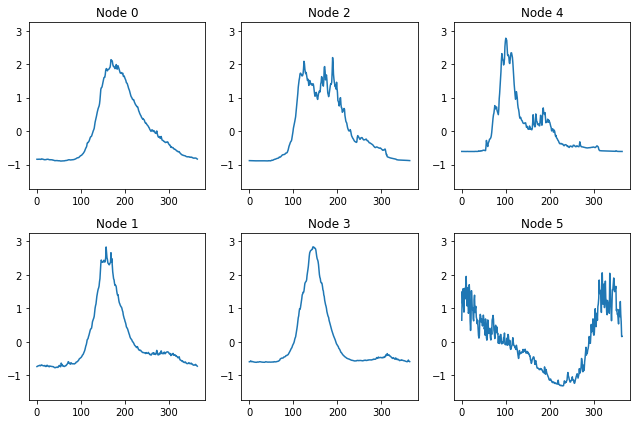

In [203]:
#visualize the SOM in map-space
fig, axes = som.plot()

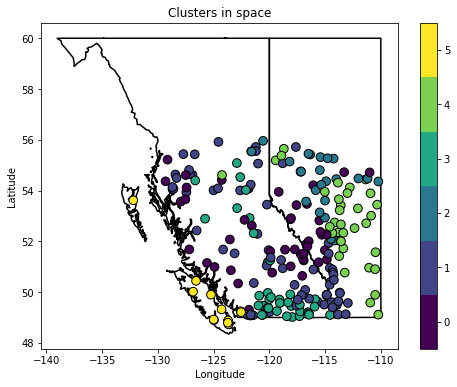

In [248]:
#visualize clusters in data-space

from matplotlib import cm
from matplotlib.colors import BoundaryNorm

fig, ax = plt.subplots(figsize = (8,6))

#colours
cmap = cm.get_cmap('viridis')
bounds = np.arange(N_nodes+1)-0.5
norm = BoundaryNorm(bounds, cmap.N)

plot_prov_ax(['AB', 'BC'], ax)
sp = ax.scatter(stationLon, stationLat, s = 75, zorder = 5, c = bmus, edgecolor = 'k', cmap = cmap, norm = norm) #observations, coloured by BMU
ax.set_xlabel('x') 
ax.set_ylabel('y')
cb = plt.colorbar(sp)
cb.set_ticks(np.arange(6))
ax.set_title('Clusters in space')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

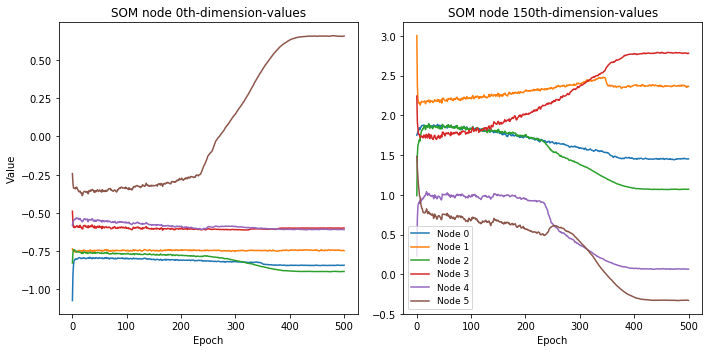

In [175]:
#visualize how som nodes in data-space change through training -- when these stabalize, it is a sign that the map has converged

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

for node in range(N_nodes):
    ax[0].plot(som.z_epochs[node,0,:].T)
    ax[1].plot(som.z_epochs[node,150,:].T, label = 'Node ' + str(node))

ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Value')
ax[0].set_title('SOM node 0th-dimension-values')
ax[1].set_title('SOM node 150th-dimension-values')
ax[1].legend(fontsize = 9)

plt.tight_layout()
plt.show()